In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tqdm import tqdm

In [17]:
input_file_path = '../../../siads591 data/processed_data/gabbard/gabbard_36H20.pkl'
freq = '36H'

output_file_path = './test_breakup_event2.mp4'

In [18]:
bitrate = 1000
dpi = 600
fps = 60
use_slice = slice(None, None, None) # 2 ways to slice the data, this is index slicing for the date range
lasts_for = pd.Timedelta("600 days")

In [33]:
df = pd.read_pickle(f'{input_file_path}')
# df = df[(df.index >= "1980-01-01") & (df.index <= "2021-01-20")] # manually set min/max range based on datetime
# df = df[(df.index >= "2000-10-01") & (df.index <= "2021-01-01")] # manually set min/max range based on datetime
# df = df[(df.index >= "2005-01-01") & (df.index <= "2015-01-01")] # manually set min/max range based on datetime
# df = df[(df.index >= "2007-01-01") & (df.index <= "2009-05-01")] # manually set min/max range based on datetime

display(df.info())
display(df.head(4))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66533939 entries, 1987-12-22 00:00:00 to 2021-01-25 12:00:00
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.2 GB


None

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
1987-12-22 00:00:00,12,63999,65535,11141
1987-12-23 12:00:00,12,63999,65535,11144
1987-12-25 00:00:00,12,63999,65535,11146
1987-12-26 12:00:00,12,63999,65535,11144


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65103479 entries, 1987-12-22 00:00:00 to 2021-01-25 12:00:00
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.2 GB


None

In [20]:
dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
dates = dates[use_slice]
print(f'{len(dates)} frames')

14917 frames


In [21]:
# debris with breakup date
satcat = pd.read_pickle("../../data/satcat_incl_breakup_dates.pkl.gz", compression="gzip")
debris_event = pd.read_csv("breakup_custom.csv").merge(satcat, how="left", left_on='US SATELLITE NUMBER', right_on='NORAD_CAT_ID').merge(satcat[satcat.OBJECT_TYPE=='DEBRIS'], how="left", left_on="launch_designator", right_on="launch_designator")[['NORAD_CAT_ID_y','US SATELLITE NUMBER', 'BREAKUP DATE']].dropna(subset=['NORAD_CAT_ID_y'])
debris_event = debris_event.rename(columns={'NORAD_CAT_ID_y':'debris_id', 'US SATELLITE NUMBER':'parent_id', 'BREAKUP DATE':'breakup_date'})
debris_event['debris_id'] = debris_event['debris_id'].astype(np.uint16)
debris_event['parent_id'] = debris_event['parent_id'].astype(np.uint16)
debris_event.loc[debris_event['parent_id'] == 25942,"breakup_date"] = "3/11/2000" # double event CBERS 1/SACI 1 R/B, attribute to earlier since the later one is dwarfed by FY1C anyways
debris_event.loc[debris_event['parent_id'] == 43947,"breakup_date"] = "3/29/2019" # microsat-r
debris_event['breakup_date'] = debris_event['breakup_date'].astype(np.datetime64)
display(debris_event.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19192 entries, 0 to 19201
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   debris_id     19192 non-null  uint16        
 1   parent_id     19192 non-null  uint16        
 2   breakup_date  19192 non-null  datetime64[ns]
dtypes: datetime64[ns](1), uint16(2)
memory usage: 374.8 KB


None

In [22]:
# breakup event display
all_ids = debris_event['parent_id'].unique()
event_display = pd.read_csv("breakup_custom.csv")[['SATELLITE NAME', 'US SATELLITE NUMBER', 'BREAKUP DATE', 'DEBRIS CATALOGED', 'ASSESSED CAUSE', 'ADDITIONAL INFORMATION', 'Show', 'Message']]
event_display = event_display[event_display['Show']]
event_display["BREAKUP DATE"] = event_display["BREAKUP DATE"].astype(np.datetime64)
event_display = event_display.sort_values(by="BREAKUP DATE")
event_display = event_display.fillna("")
event_display["message"] = event_display.apply(lambda x:f'[{x["BREAKUP DATE"].month_name()} {x["BREAKUP DATE"].year}]  {x["SATELLITE NAME"]}: {x["Message"]} (+{x["DEBRIS CATALOGED"]})', axis=1)

In [25]:
def get_new_debris(devents, cdf, e):
    debris = devents[(devents.breakup_date + lasts_for > e) & (devents.breakup_date < e)].copy()
    debris = debris.merge(cdf, left_on="debris_id", right_on="NORAD_CAT_ID")
    debris = debris.drop(columns=['debris_id'])
    debris['color'] = (1-((e - debris.breakup_date) / (lasts_for))) * 1
    debris['color2'] = debris.color.apply(lambda x: f'#014762{"{:02x}".format(int(x*255))}')
    debris['color'] = debris.color.apply(lambda x: f'#771300{"{:02x}".format(int(x*255))}')
    return debris

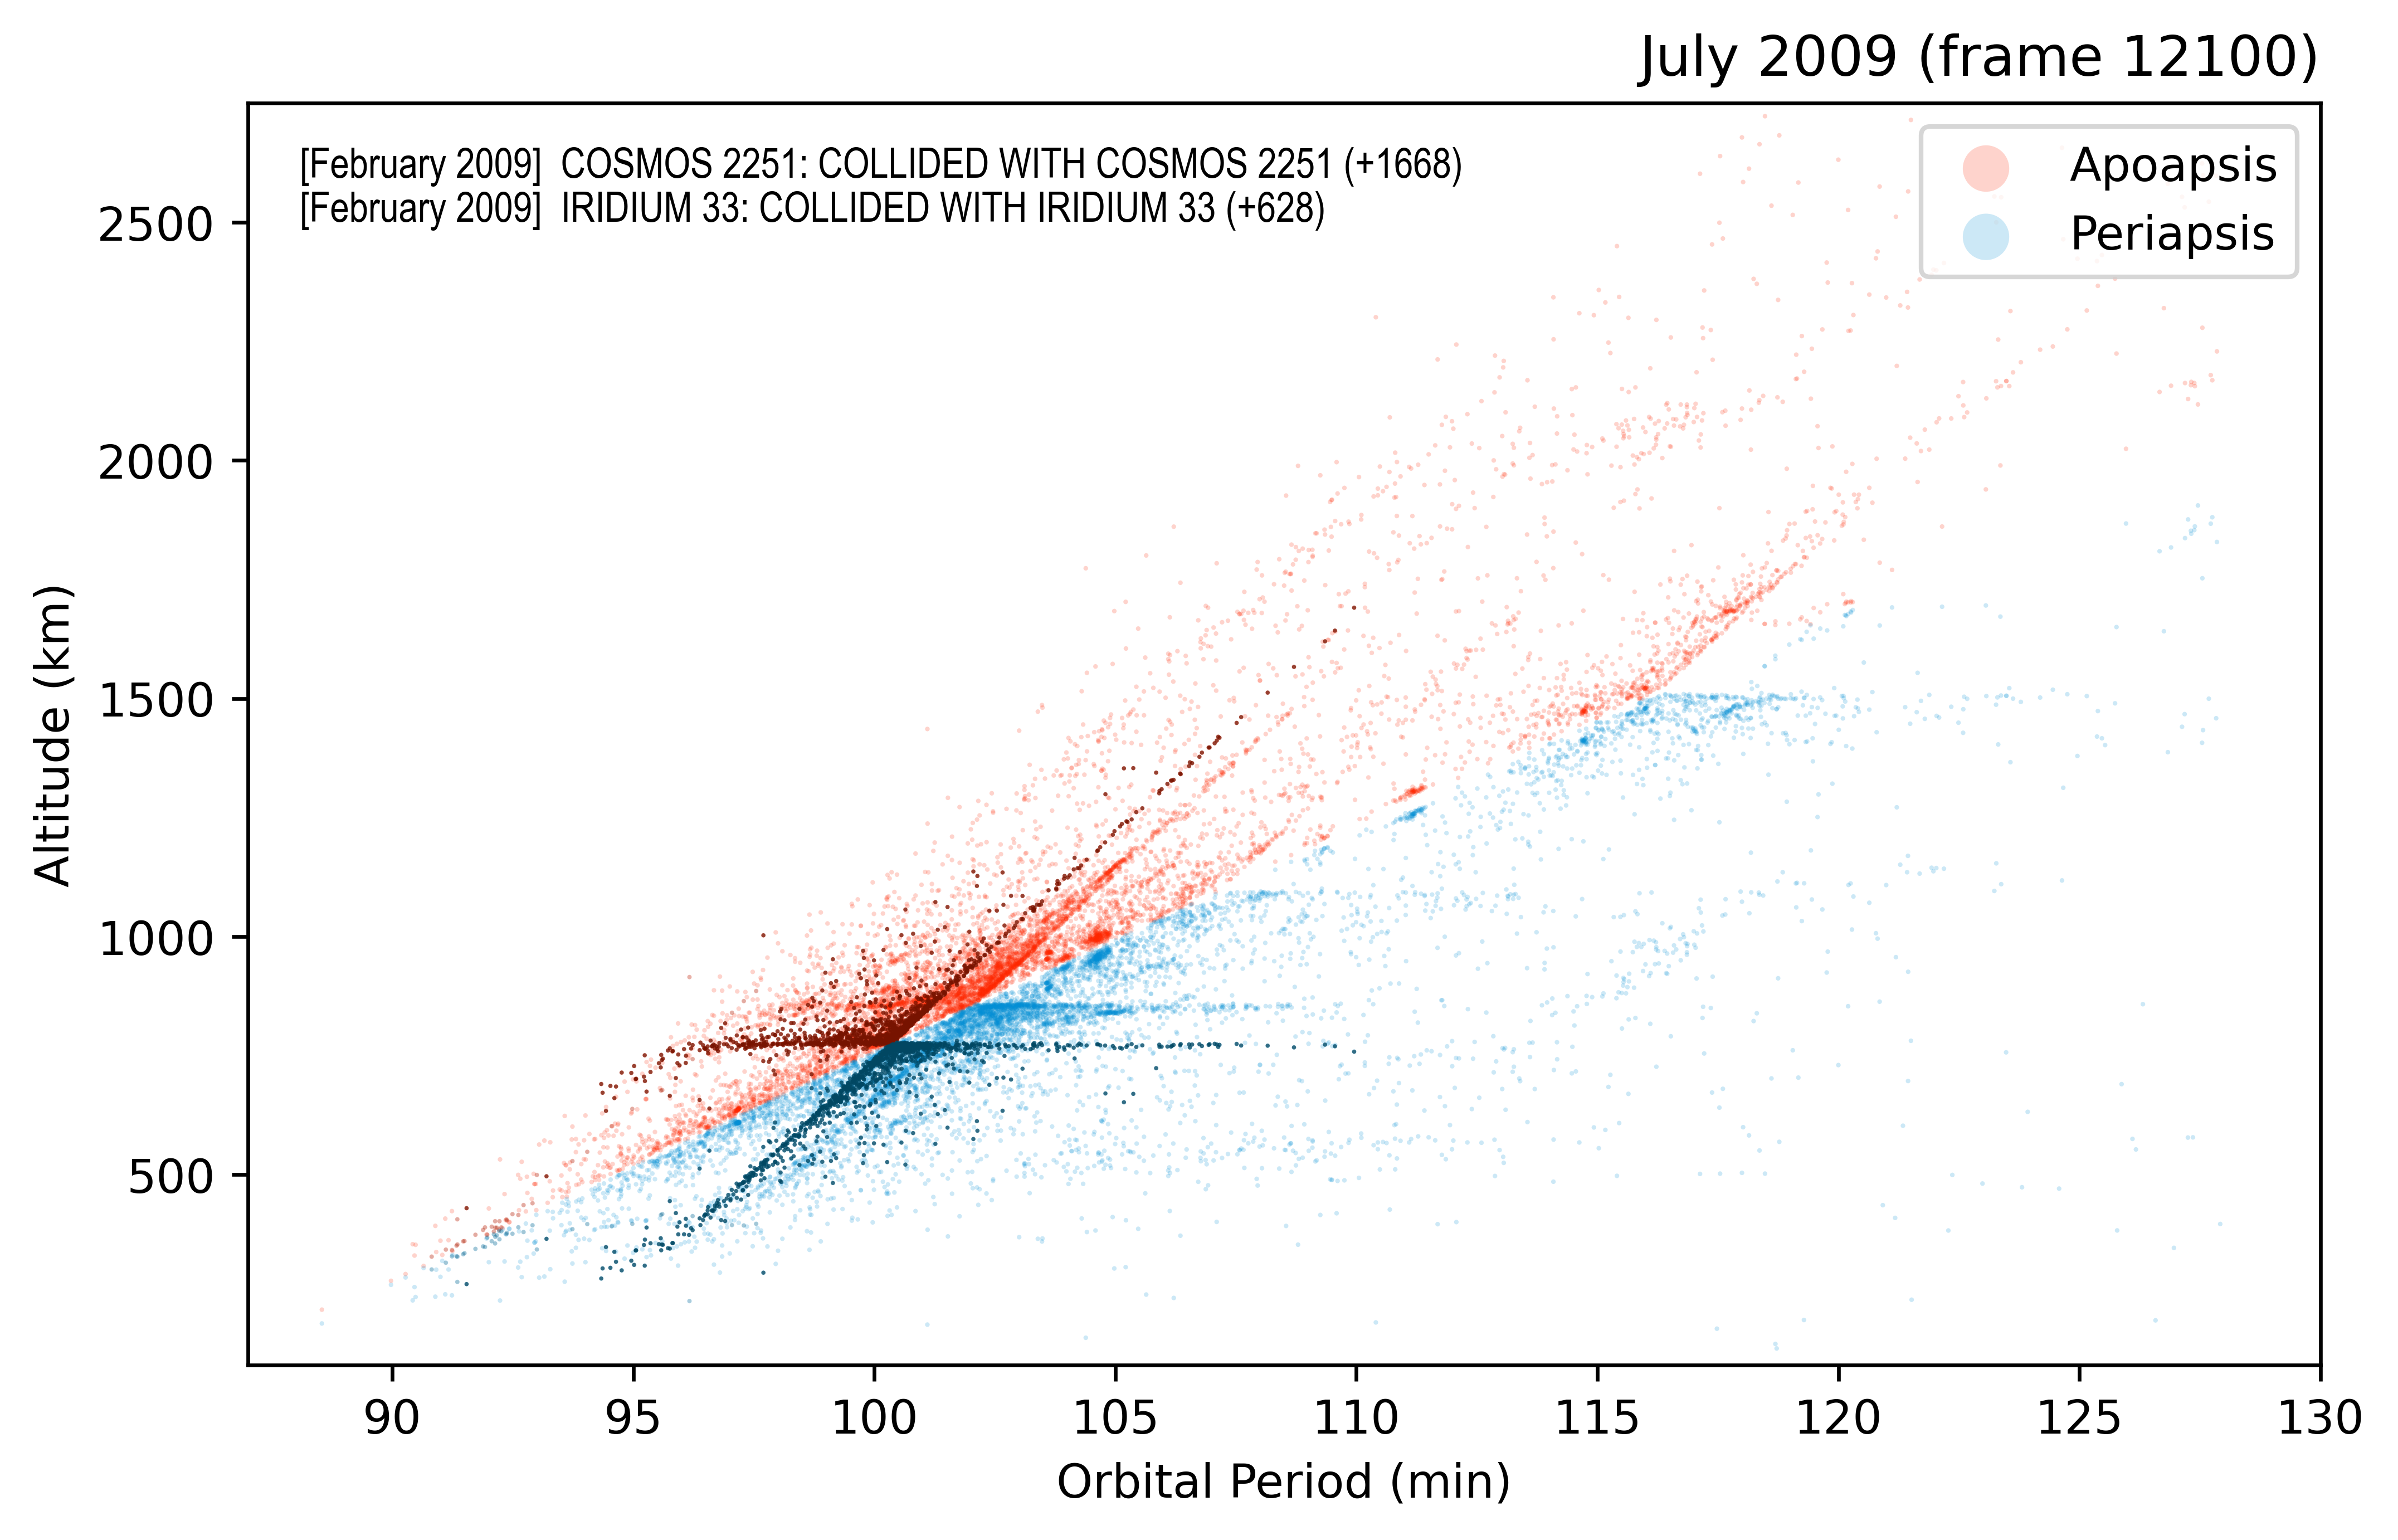

In [34]:
## set this to a specific frame number to draw only 1 frame in the notebook to test output
# Set None to generate full video
draw_one_frame = None

fig, ax = plt.subplots(dpi=dpi, figsize=(8,5))
fig.set_facecolor("white")

# turns out that you can scale the axis label!
# do that instead of wasting computation time on data conversion
ax.set_xlim(87*500,130*500)
ax.set_ylim(100*20,2750*20)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/500))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/20))
ax.yaxis.set_major_formatter(ticks_y)

ax.set_xlabel("Orbital Period (min)")
ax.set_ylabel("Altitude (km)")
artists = []
text_artist = []
text_cache = set()

def plot_it(ax,e):
    global df, event_display, debris_event, text_artist, text_cache, artists
    
    # get data for frame
    cdf = df[df.index==e]
    debris = get_new_debris(debris_event, cdf, e)
    
#     s = slice(None,125,2)
#     for a,b,c in zip(cdf.period_series[s], cdf.apoapsis_series[s], cdf.periapsis_series[s]):
#         plt.plot([a, a], [b, c], '-', color='purple', lw=0.5, alpha= 0.3)
    
    # draw text annotations
    events = event_display[(event_display['BREAKUP DATE'] + lasts_for*2/3 > e) & (event_display['BREAKUP DATE'] < e)]
    if text_cache != set(events.index):
        text_cache = set(events.index)
        for a in text_artist:
            a.remove()
        text_artist = []
        for i, event in enumerate(list(events.iterrows())):
            a = ax.text(0.025, 0.95 - (i*0.035), event[1]['message'], color='k',
                        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes,
                        fontsize=9, fontname='Arial Narrow')
            text_artist.append(a)
    
    apo = ax.scatter(cdf.PERIOD_x500, cdf.APOAPSIS_x20, color='#fe2700', marker='o', edgecolors='none', alpha=0.2, s=1, label="Apoapsis")
    peri = ax.scatter(cdf.PERIOD_x500, cdf.PERIAPSIS_x20, color='#038fd5', marker='o', edgecolors='none', alpha=0.2, s=1, label="Periapsis")
    dapo = ax.scatter(debris.PERIOD_x500, debris.APOAPSIS_x20, color=debris.color, marker='o', edgecolors='none', s=0.8, label="_")
    dperi = ax.scatter(debris.PERIOD_x500, debris.PERIAPSIS_x20, color=debris.color2, marker='o', edgecolors='none', s=0.8, label="_")
    plt.legend(loc="upper right", numpoints=1, fontsize=10, markerscale=10)
    
    return [apo,peri,dapo,dperi]

def update(f):
    global pbar, artists, yr
    i, date = f
    ax.set_title(f"{date.month_name()} {date.year} (frame {i})", loc='right')
    for a in artists:
        a.remove()
    artists = plot_it(ax,date)
    pbar.update(1)

if type(draw_one_frame) == int:
    update((draw_one_frame,dates[draw_one_frame]))
else:
    pbar = tqdm(total=len(dates)+1)
    ani = FuncAnimation(fig, update, list(enumerate(dates)))
    writervideo = FFMpegWriter(fps=fps, bitrate=bitrate)
    ani.save(f'{output_file_path}', writer=writervideo, dpi=dpi)
    pbar.close()